In [10]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from typing import Iterable
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
def compute_lisi(X: np.array, metadata: pd.DataFrame, label_colnames: Iterable[str], perplexity: float = 30):
    """Compute the Local Inverse Simpson Index (LISI) for each column in metadata."""
    n_cells = metadata.shape[0]
    n_labels = len(label_colnames)
    knn = NearestNeighbors(n_neighbors=int(perplexity * 3), algorithm='kd_tree').fit(X)
    distances, indices = knn.kneighbors(X)
    indices = indices[:, 1:]
    distances = distances[:, 1:]
    lisi_df = np.zeros((n_cells, n_labels))
    for i, label in enumerate(label_colnames):
        labels = pd.Categorical(metadata[label])
        n_categories = len(labels.categories)
        simpson = compute_simpson(distances.T, indices.T, labels, n_categories, perplexity)
        lisi_df[:, i] = 1 / simpson
    return lisi_df

def compute_simpson(distances: np.ndarray, indices: np.ndarray, labels: pd.Categorical, n_categories: int, perplexity: float, tol: float=1e-5):
    """Helper function to compute Simpson's index."""
    n = distances.shape[1]
    P = np.zeros(distances.shape[0])
    simpson = np.zeros(n)
    logU = np.log(perplexity)
    for i in range(n):
        beta = 1
        betamin = -np.inf
        betamax = np.inf
        P = np.exp(-distances[:, i] * beta)
        P_sum = np.sum(P)
        if P_sum == 0:
            H = 0
            P = np.zeros(distances.shape[0])
        else:
            H = np.log(P_sum) + beta * np.sum(distances[:, i] * P) / P_sum
            P = P / P_sum
        Hdiff = H - logU
        while abs(Hdiff) > tol:
            if Hdiff > 0:
                betamin = beta
                beta = beta * 2 if not np.isfinite(betamax) else (beta + betamax) / 2
            else:
                betamax = beta
                beta = beta / 2 if not np.isfinite(betamin) else (beta + betamin) / 2
            P = np.exp(-distances[:, i] * beta)
            P_sum = np.sum(P)
            if P_sum == 0:
                H = 0
                P = np.zeros(distances.shape[0])
            else:
                H = np.log(P_sum) + beta * np.sum(distances[:, i] * P) / P_sum
                P = P / P_sum
            Hdiff = H - logU
        for label_category in labels.categories:
            ix = indices[:, i]
            q = labels[ix] == label_category
            if np.any(q):
                P_sum = np.sum(P[q])
                simpson[i] += P_sum * P_sum
    return simpson

In [19]:
# Load the data "Microbiome three centers"
data_before_correction = pd.read_csv('/home/yuliya/repos/other/removeBatch/evaluation_data/proteomics/before/balanced_central_intensities_filtered.tsv', sep='\t').transpose()
data_after_correction = pd.read_csv('/home/yuliya/repos/other/removeBatch/evaluation_data/proteomics/after/balanced_central_intensities_corrected.tsv', sep='\t').transpose()
metadata = pd.read_csv('/home/yuliya/repos/other/removeBatch/evaluation_data/proteomics/after/balanced_central_batch_info.tsv', sep='\t').set_index('file')[['lab', 'condition']]

# replace NA with 0
data_before_correction.fillna(0, inplace=True)
data_after_correction.fillna(0, inplace=True)

# Check for missing values in the microbiome data before and after correction
print("Missing values in data before correction:", data_before_correction.isnull().sum().sum())
print("Missing values in data after correction:", data_after_correction.isnull().sum().sum())

# Check for missing values in the metadata
print("Missing values in metadata:", metadata.isnull().sum().sum())

missing_values_per_column = metadata.isnull().sum()
print("Missing values per column:", missing_values_per_column[missing_values_per_column > 0])


# Ensure the sample order in metadata matches the microbiome data
metadata_before = metadata.loc[data_before_correction.index]
metadata_after = metadata.loc[data_after_correction.index]
print("Metadata shape before correction:", metadata_before.shape)


Missing values in data before correction: 0
Missing values in data after correction: 0
Missing values in metadata: 0
Missing values per column: Series([], dtype: int64)
Metadata shape before correction: (118, 2)


In [13]:
# # Load the data "Microbiome four centers"
# data_before_correction = pd.read_csv('./data/Microbiome/logmin_four_centers.tsv', sep='\t').transpose()
# data_after_correction = pd.read_csv('./data/Microbiome/logmin_four_centers_corrected.tsv', sep='\t').transpose()
# metadata = pd.read_csv('./data/Microbiome/metadata_four_centers.tsv', sep='\t').set_index('sample')[['Study_Equip', 'class']]

# # Check for missing values in the microbiome data before and after correction
# print("Missing values in data before correction:", data_before_correction.isnull().sum().sum())
# print("Missing values in data after correction:", data_after_correction.isnull().sum().sum())

# # Check for missing values in the metadata
# print("Missing values in metadata:", metadata.isnull().sum().sum())

# missing_values_per_column = metadata.isnull().sum()
# print("Missing values per column:", missing_values_per_column[missing_values_per_column > 0])


# # Ensure the sample order in metadata matches the microbiome data
# metadata_before = metadata.loc[data_before_correction.index]
# metadata_after = metadata.loc[data_after_correction.index]


In [14]:
# Load the data "PRoteomics balanced"


In [20]:
# Compute LISI scores
labels_to_use = ['lab', 'condition']
lisi_before = compute_lisi(data_before_correction.values, metadata_before, labels_to_use)
lisi_after = compute_lisi(data_after_correction.values, metadata_after, labels_to_use)
lisi_change = lisi_after - lisi_before
# Calculate percentage change
change_percentage = (lisi_change) / lisi_before * 100

# Convert LISI arrays to DataFrame for better visualization
lisi_before_df = pd.DataFrame(lisi_before, columns=labels_to_use, index=metadata_before.index)
lisi_after_df = pd.DataFrame(lisi_after, columns=labels_to_use, index=metadata_after.index)
lisi_change_df = pd.DataFrame(lisi_change,columns=labels_to_use, index=metadata_after.index)
change_percentage_df =  pd.DataFrame(change_percentage,columns=labels_to_use, index=metadata_after.index)



# Print results
print(lisi_before_df.head())
print(lisi_after_df.head())
print(lisi_change_df.head())
print(change_percentage_df.head())

# Writing DataFrame to CSV file
# lisi_before_df.to_csv('lisi_before_Microb.csv', index=False)  
# lisi_after_df.to_csv('lisi_after_Microb.csv', index=False)  
# lisi_change_df.to_csv('lisi_change_Microb.csv', index=False)


                             lab  condition
Ref8537_QC1_20230414_1  1.673564   1.367716
Ref8537_QC2_20230414_1  1.674180   1.290464
Ref8537_QC3_20230414_1  1.522131   1.375524
Ref8537_QC4_20230414_1  1.487248   1.434678
Ref8537_S4_20230414     1.548100   1.374641
                             lab  condition
Ref8537_QC1_20230414_1  2.432764   1.055237
Ref8537_QC2_20230414_1  2.070742   1.048697
Ref8537_QC3_20230414_1  2.369579   1.068373
Ref8537_QC4_20230414_1  2.335739   1.138015
Ref8537_S4_20230414     3.068348   1.045108
                             lab  condition
Ref8537_QC1_20230414_1  0.759200  -0.312479
Ref8537_QC2_20230414_1  0.396562  -0.241767
Ref8537_QC3_20230414_1  0.847448  -0.307152
Ref8537_QC4_20230414_1  0.848491  -0.296662
Ref8537_S4_20230414     1.520249  -0.329532
                              lab  condition
Ref8537_QC1_20230414_1  45.364236 -22.846784
Ref8537_QC2_20230414_1  23.686920 -18.734880
Ref8537_QC3_20230414_1  55.675151 -22.329798
Ref8537_QC4_20230414_1  57.0

In [10]:
# lisi_before_df = pd.read_csv('LISI/lisi_before_Microb.csv')
# lisi_after_df = pd.read_csv('LISI/lisi_after_Microb.csv')
# lisi_change_df = pd.read_csv('LISI/lisi_change_Microb.csv')

# metadata = pd.read_csv('evaluation_microbiom_data/before/metadata_three_centers.tsv', sep='\t').set_index('sample')[['Study_Equip', 'class']]

# lisi_before_df = lisi_before_df.set_index(metadata.index)
# lisi_after_df = lisi_after_df.set_index(metadata.index)
# lisi_change_df = lisi_change_df.set_index(metadata.index)

In [21]:
def scale_lisi(score_1, score_2, nbatches, class_true=False):
    
    if class_true:
        #scale clisi score to 0 bad 1 good
        score_1 = (nbatches - score_1)/(nbatches-1)
        score_2 = (nbatches - score_2)/(nbatches-1)
    else:
        #scale iLISI score to 0 bad 1 good
        score_1 = (score_1 - 1)/(nbatches-1)
        score_2 = (score_2 - 1)/(nbatches-1)
    return score_1, score_2


nbatches = len(np.unique(metadata['lab']))

lisi_after_df_scaled = lisi_after_df.copy()
lisi_before_df_scaled = lisi_before_df.copy()

lisi_after_df_scaled['lab'], lisi_before_df_scaled['lab'] = scale_lisi(
    lisi_after_df_scaled['lab'], lisi_before_df_scaled['lab'], 
    len(np.unique(metadata['lab'])), class_true=False)
lisi_after_df_scaled['condition'], lisi_before_df_scaled['condition'] = scale_lisi(
    lisi_after_df_scaled['condition'], lisi_before_df_scaled['condition'],
    len(np.unique(metadata['condition'])), class_true=True)

In [22]:
np.unique(metadata['lab'])

array(['lab_A', 'lab_B', 'lab_C', 'lab_D', 'lab_E'], dtype=object)

In [23]:
lisi_after_df_scaled.head()

,lab,condition
Ref8537_QC1_20230414_1,0.358191,0.944763
Ref8537_QC2_20230414_1,0.267686,0.951303
Ref8537_QC3_20230414_1,0.342395,0.931627
Ref8537_QC4_20230414_1,0.333935,0.861985
Ref8537_S4_20230414,0.517087,0.954892


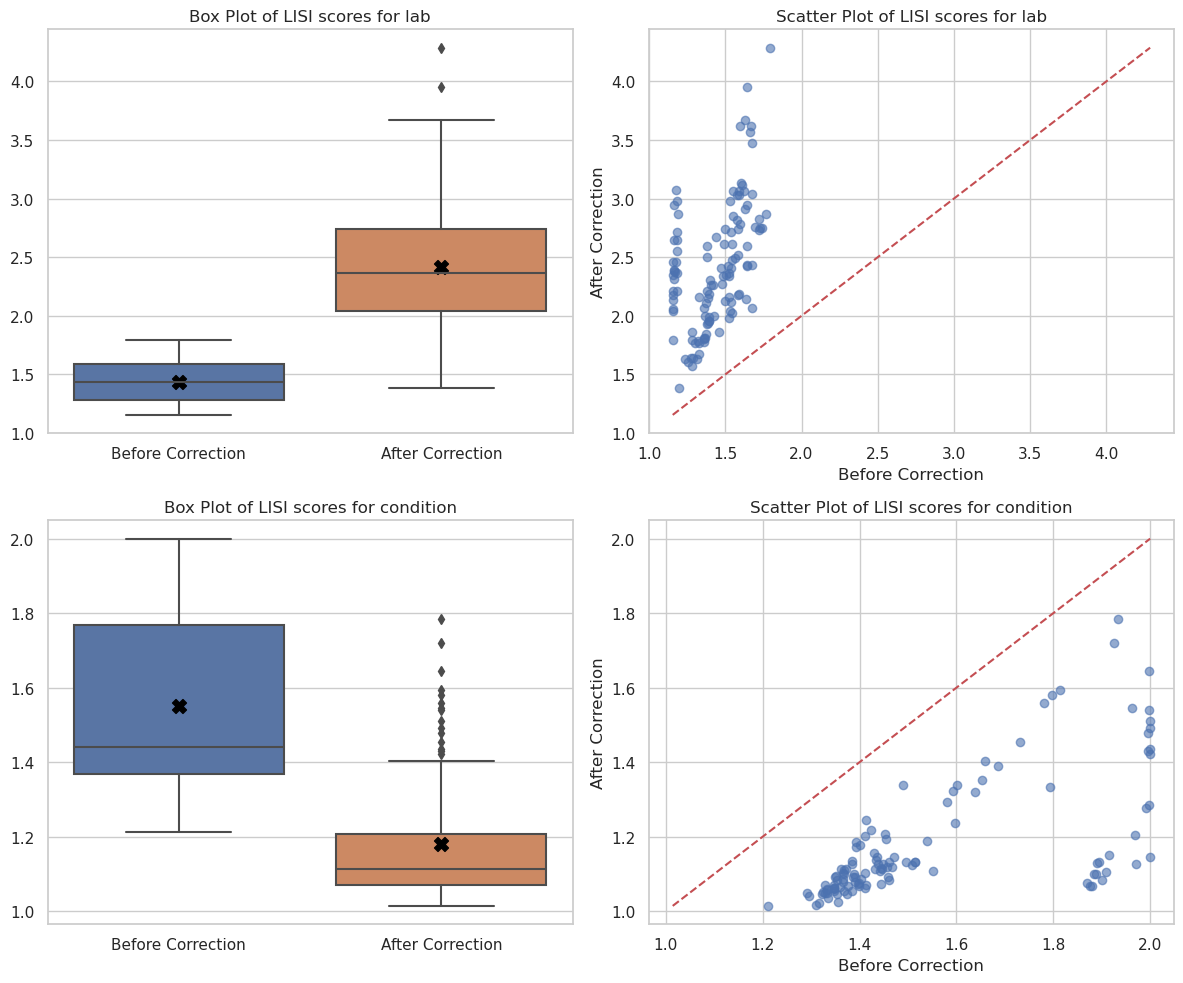

In [24]:
def plot_lisi_scores(lisi_before_df, lisi_after_df, labels):
    # Set the style
    sns.set(style="whitegrid")

    # Create a figure for the plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, label in enumerate(labels):
        # Prepare data for box plot: concatenate along the columns (axis=1)
        combined_data = pd.concat([lisi_before_df[[label]], lisi_after_df[[label]]], axis=1)
        combined_data.columns = ['Before Correction', 'After Correction']  # renaming columns for clarity

        # Box plot for before and after correction
        sns.boxplot(data=combined_data, ax=axes[i*2]).set_title(f'Box Plot of LISI scores for {label}')
        # add median using "X" symbol
        axes[i*2].scatter([0, 1], combined_data.mean(), color='black', marker='X', s=100)

        # Scatter plot for before vs after
        axes[i*2+1].scatter(lisi_before_df[label], lisi_after_df[label], alpha=0.6)
        axes[i*2+1].set_title(f'Scatter Plot of LISI scores for {label}')
        axes[i*2+1].set_xlabel('Before Correction')
        axes[i*2+1].set_ylabel('After Correction')
        # Add a reference line
        min_val = min(lisi_before_df[label].min(), lisi_after_df[label].min())
        max_val = max(lisi_before_df[label].max(), lisi_after_df[label].max())
        axes[i*2+1].plot([min_val, max_val], [min_val, max_val], 'r--')  

    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_lisi_scores(lisi_before_df, lisi_after_df, ['lab', 'condition'])


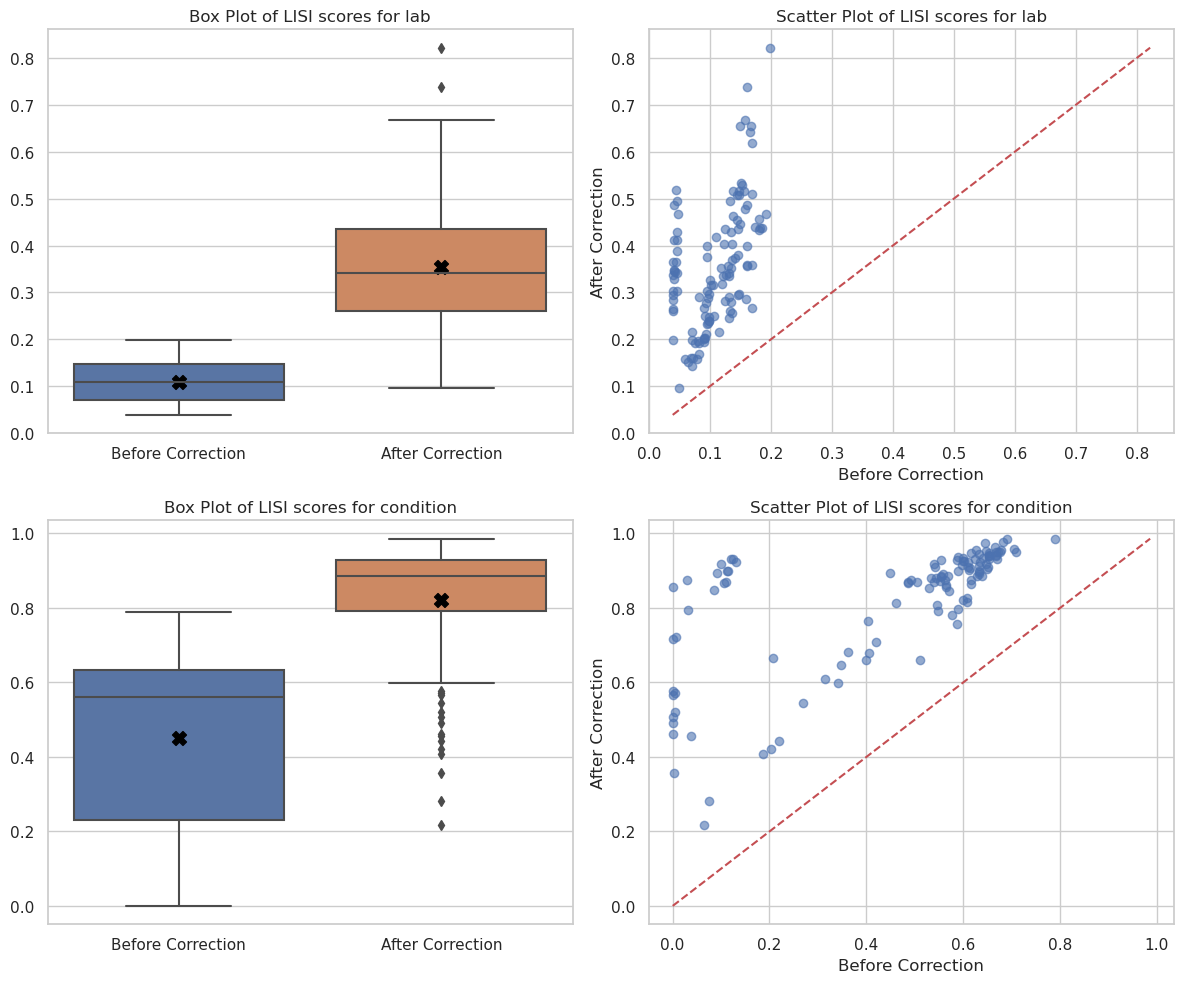

In [26]:
plot_lisi_scores(lisi_before_df_scaled, lisi_after_df_scaled, ['lab', 'condition'])

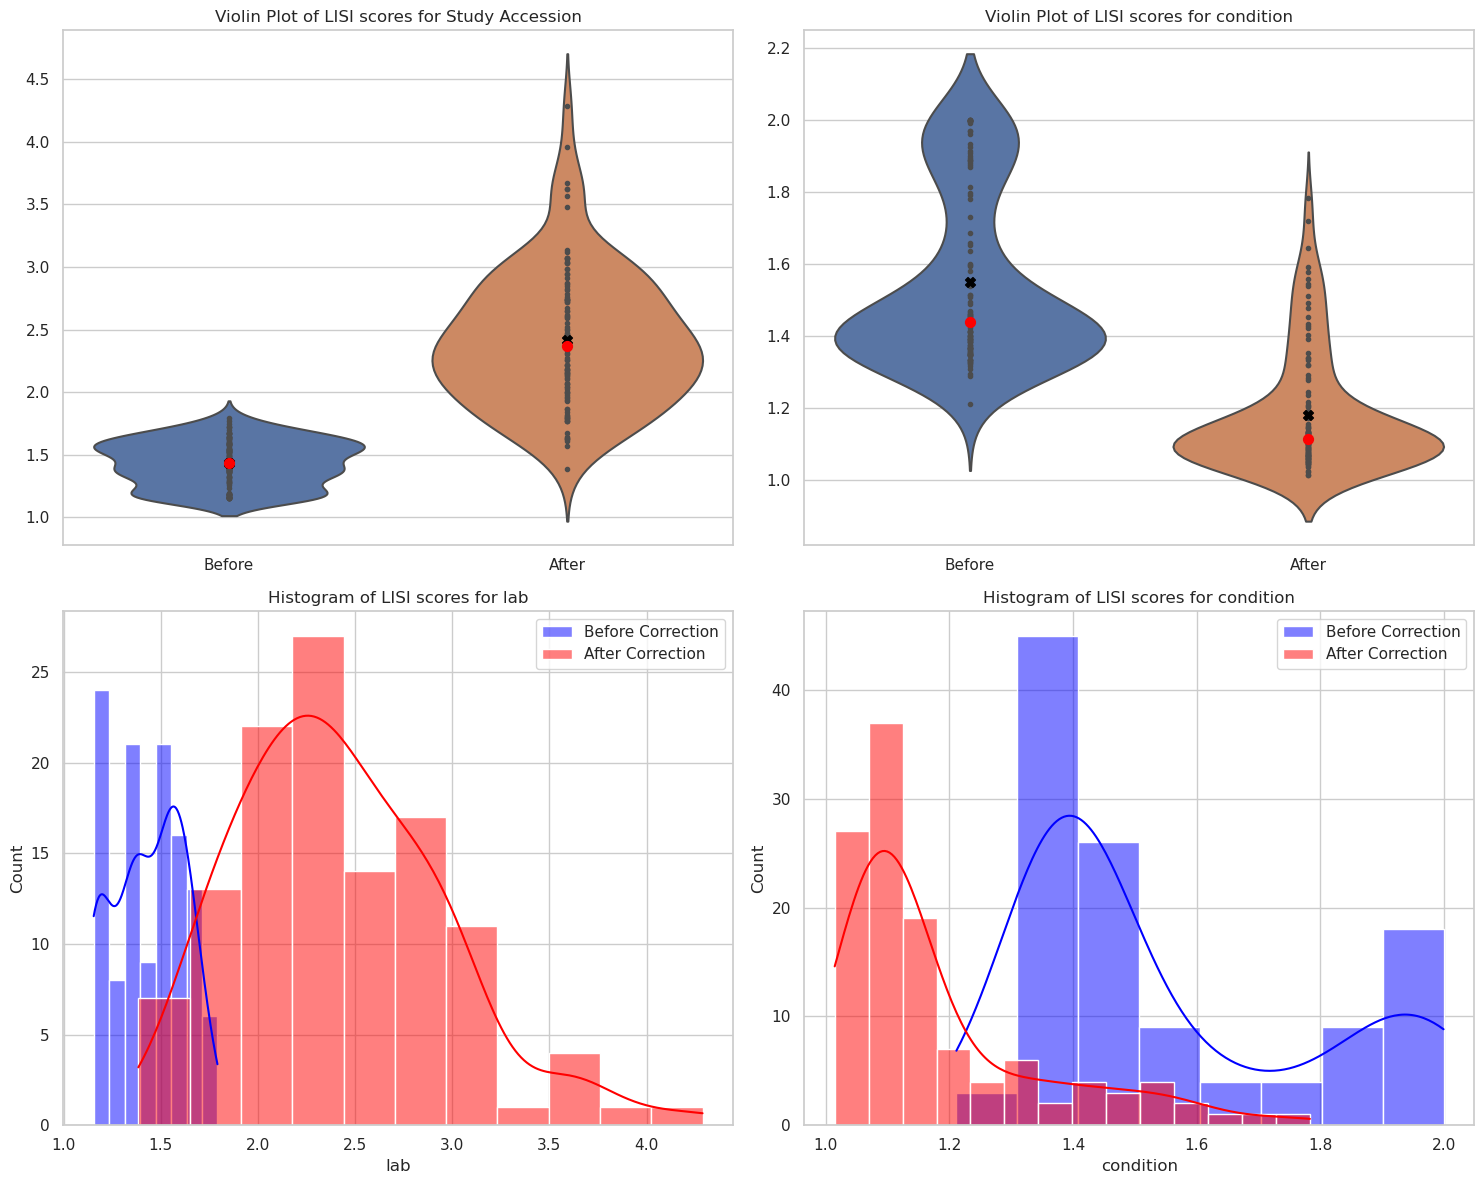

In [27]:


def additional_plots(lisi_before_df, lisi_after_df):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Correcting Violin plots
    violin_data = pd.concat([lisi_before_df['lab'], lisi_after_df['lab']], axis=1, keys=['Before', 'After'])
    sns.violinplot(data=violin_data, ax=axes[0, 0], inner="point", scale="width")
    # add mean and median to violins
    axes[0, 0].scatter([0, 1], violin_data.mean(), color='black', marker='X', s=50)
    axes[0, 0].scatter([0, 1], violin_data.median(), color='red', marker='o', s=50)
    axes[0, 0].set_title('Violin Plot of LISI scores for Study Accession')

    # Uncommenting and correcting Heatmaps
    violin_data = pd.concat([lisi_before_df['condition'], lisi_after_df['condition']], axis=1, keys=['Before', 'After'])
    sns.violinplot(data=violin_data, ax=axes[0, 1], inner="point", scale="width")
    axes[0, 1].scatter([0, 1], violin_data.mean(), color='black', marker='X', s=50)
    axes[0, 1].scatter([0, 1], violin_data.median(), color='red', marker='o', s=50)
    axes[0, 1].set_title('Violin Plot of LISI scores for condition')

    # Histograms
    sns.histplot(lisi_before_df['lab'], color="blue", label="Before Correction", kde=True, ax=axes[1, 0])
    sns.histplot(lisi_after_df['lab'], color="red", label="After Correction", kde=True, ax=axes[1, 0])
    axes[1, 0].legend()
    axes[1, 0].set_title('Histogram of LISI scores for lab')


    sns.histplot(lisi_before_df['condition'], color="blue", label="Before Correction", kde=True, ax=axes[1, 1])
    sns.histplot(lisi_after_df['condition'], color="red", label="After Correction", kde=True, ax=axes[1, 1])
    axes[1, 1].legend()
    axes[1, 1].set_title('Histogram of LISI scores for condition')

    plt.tight_layout()
    plt.show()


# Call the plotting function
additional_plots(lisi_before_df, lisi_after_df)


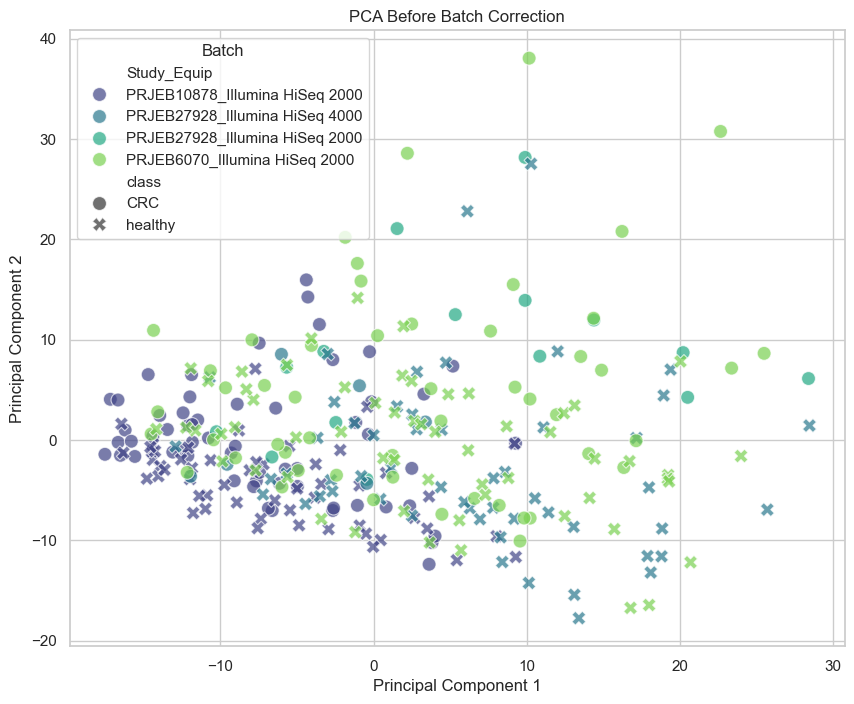

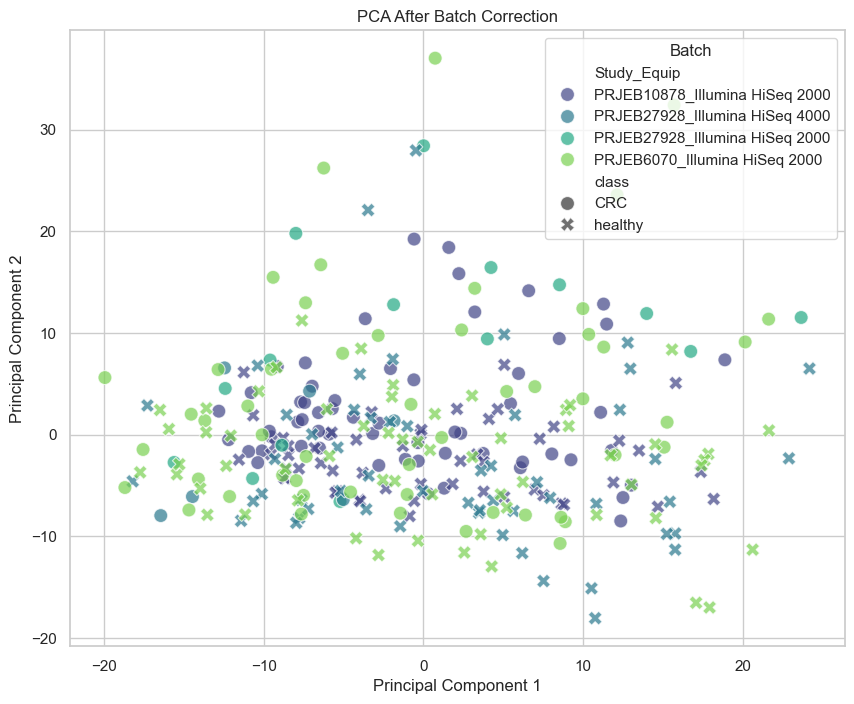

In [28]:


def perform_pca_and_plot(data, metadata, title):
    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Perform PCA
    pca = PCA(n_components=2)  # Reduce to two principal components
    principal_components = pca.fit_transform(data_scaled)
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=data.index)

    # Merge with metadata for plotting
    pca_df = pca_df.merge(metadata, left_index=True, right_index=True)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='Study_Equip', style='class', data=pca_df, palette='viridis', s=100, alpha=0.7)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Batch', loc='best')
    plt.grid(True)
    plt.show()

# Perform PCA and plot for both datasets
perform_pca_and_plot(data_before_correction, metadata_before, 'PCA Before Batch Correction')
perform_pca_and_plot(data_after_correction, metadata_after, 'PCA After Batch Correction')
